In [ ]:
import json
import pandas as pd
import numpy as np
import re
import nltk
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.preprocessing import LabelEncoder

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
with open("datasetMin.json", "r", encoding="utf-8") as f:
    data = json.load(f)

df = pd.DataFrame.from_records(data)
df["text"] = df["title"].fillna("") + " " + df["content"].fillna("")

In [ ]:
df.head()

,title,content,ministry,text
0,Минэнерго ответило на сообщения иностранных СМ...,Министерство энергетики Казахстана заявило о п...,Министерство энергетики,Минэнерго ответило на сообщения иностранных СМ...
1,Минэнерго РК выступило с заявлением после публ...,Министерство энергетики Казахстана прокомменти...,Министерство энергетики,Минэнерго РК выступило с заявлением после публ...
2,Структура Минэнерго отсудила у оператора Карач...,Республиканское государственное учреждение «Ка...,Министерство энергетики,Структура Минэнерго отсудила у оператора Карач...
3,Казахстан провел стратегические переговоры с л...,Делегация Республики Казахстан во главе с Мини...,Министерство энергетики,Казахстан провел стратегические переговоры с л...
4,Контракт на разведку и добычу углеводородов по...,Между Министерством энергетики Республики Каза...,Министерство энергетики,Контракт на разведку и добычу углеводородов по...


In [ ]:
df.tail()

,title,content,ministry,text
997,Премьера балетной постановки «Легенды степей» ...,На сцене одного из ведущих театров Алматы прош...,another,Премьера балетной постановки «Легенды степей» ...
998,В Кокшетау прошёл эко-форум о защите озёр региона,"В Кокшетау состоялся эко-форум, посвящённый со...",another,В Кокшетау прошёл эко-форум о защите озёр реги...
999,Активисты в Таразе организовали велопробег в ч...,"В Таразе состоялся масштабный велопробег, приу...",another,Активисты в Таразе организовали велопробег в ч...
1000,В Актау обсудили запуск системы электронного д...,На круглом столе в Актау представители городск...,another,В Актау обсудили запуск системы электронного д...
1001,Шымкент принял фестиваль стрит-арта с участием...,"В Шымкенте завершился фестиваль стрит-арта, со...",another,Шымкент принял фестиваль стрит-арта с участием...


In [ ]:
MINISTRY_KEYWORDS = {
    "Министерство энергетики": [
        "минэнерго", "нефть", "газ", "электроэнергия", "топливо", "опек", "добыча",
        "казмунайгаз", "тенгиз", "кашаган", "атом", "аэс", "уран", "гэс", "вии",
        "бензин", "дизель", "энергобаланс", "энергобезопасность", "мощности",
        "экспорт", "импорт", "ncoc", "chevron", "cnpc", "exxonmobil", "shell", "kegoc",
        "кегок", "samruk-energy", "samruk", "petroleum", "энерджи", "энерго"
    ],
    "Министерство внутренних дел": [
        "мвд", "полиция", "уголовное дело", "арест", "задержание", "преступление",
        "следствие", "оперативник", "патруль", "участковый", "угроза", "безопасность",
        "дпс", "дознание", "министерство внутренних дел", "кабмин", "госслужба"
    ],
    "Министерство экологии и природных ресурсов": [
        "экология", "природа", "выбросы", "отходы", "река", "вода", "почва",
        "озеленение", "климат", "переработка", "загрязнение", "свалка", "экопроект",
        "утиль", "ресайклинг", "мусор", "нацпарк", "гидрология", "лесхоз",
        "greenpeace", "kazhydromet", "экосфера", "ecocenter", "степногорский завод"
    ],
    "Министерство сельского хозяйства": [
        "минсельхоз", "фермер", "агро", "зерно", "пшеница", "ячмень", "урожай",
        "животноводство", "растениеводство", "молоко", "мясо", "субсидии", "госсубсидии",
        "сельхоз", "удобрения", "агротехника", "трактор", "зернохранилище",
        "казагро", "байсерке-агро", "казНИИЗиР", "агрофирма", "айдарбек сапаров"
    ]
}


In [ ]:
stemmer = SnowballStemmer("russian")
stop_words = set(stopwords.words("russian"))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^а-яa-z0-9 ]", " ", text)
    tokens = [stemmer.stem(w) for w in text.split() if w not in stop_words]
    return " ".join(tokens)

df["clean_text"] = df["text"].apply(clean_text)

In [ ]:
def keyword_vector(text, keyword_dict):
    text = text.lower()
    return [int(any(kw in text for kw in keyword_dict[k])) for k in sorted(keyword_dict.keys())]

kw_features = np.array([keyword_vector(t, MINISTRY_KEYWORDS) for t in df["text"]])
kw_input_dim = kw_features.shape[1]

In [ ]:
X_text = df["clean_text"].values
y = df["ministry"].values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
NUM_CLASSES = len(label_encoder.classes_)


In [ ]:
X_train_text, X_test_text, X_train_kw, X_test_kw, y_train, y_test = train_test_split(
    X_text, kw_features, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

In [ ]:
max_tokens = 10000
output_seq_len = 200

text_vectorizer = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode='int',
    output_sequence_length=output_seq_len
)
text_vectorizer.adapt(X_train_text)

text_input = layers.Input(shape=(1,), dtype=tf.string, name="text_input")
kw_input = layers.Input(shape=(kw_input_dim,), dtype=tf.float32, name="kw_input")

x = text_vectorizer(text_input)
x = layers.Embedding(max_tokens, 128)(x)
x = layers.Conv1D(128, 5, activation='relu', padding='same')(x)
x = layers.GlobalMaxPooling1D()(x)

merged = layers.concatenate([x, kw_input])
merged = layers.Dense(64, activation='relu')(merged)
merged = layers.Dropout(0.2)(merged)
output = layers.Dense(NUM_CLASSES, activation='softmax')(merged)

model = tf.keras.Model(inputs=[text_input, kw_input], outputs=output)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization… │ (None, 200)       │          0 │ text_input[0][0]  │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 200, 128)  │  1,280,000 │ text_vectorizati… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 200, 128)  │     82,048 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_1[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ kw_input            │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 132)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ kw_input[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,512 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 5)         │        325 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,370,885 (5.23 MB)

 Trainable params: 1,370,885 (5.23 MB)

 Non-trainable params: 0 (0.00 B)

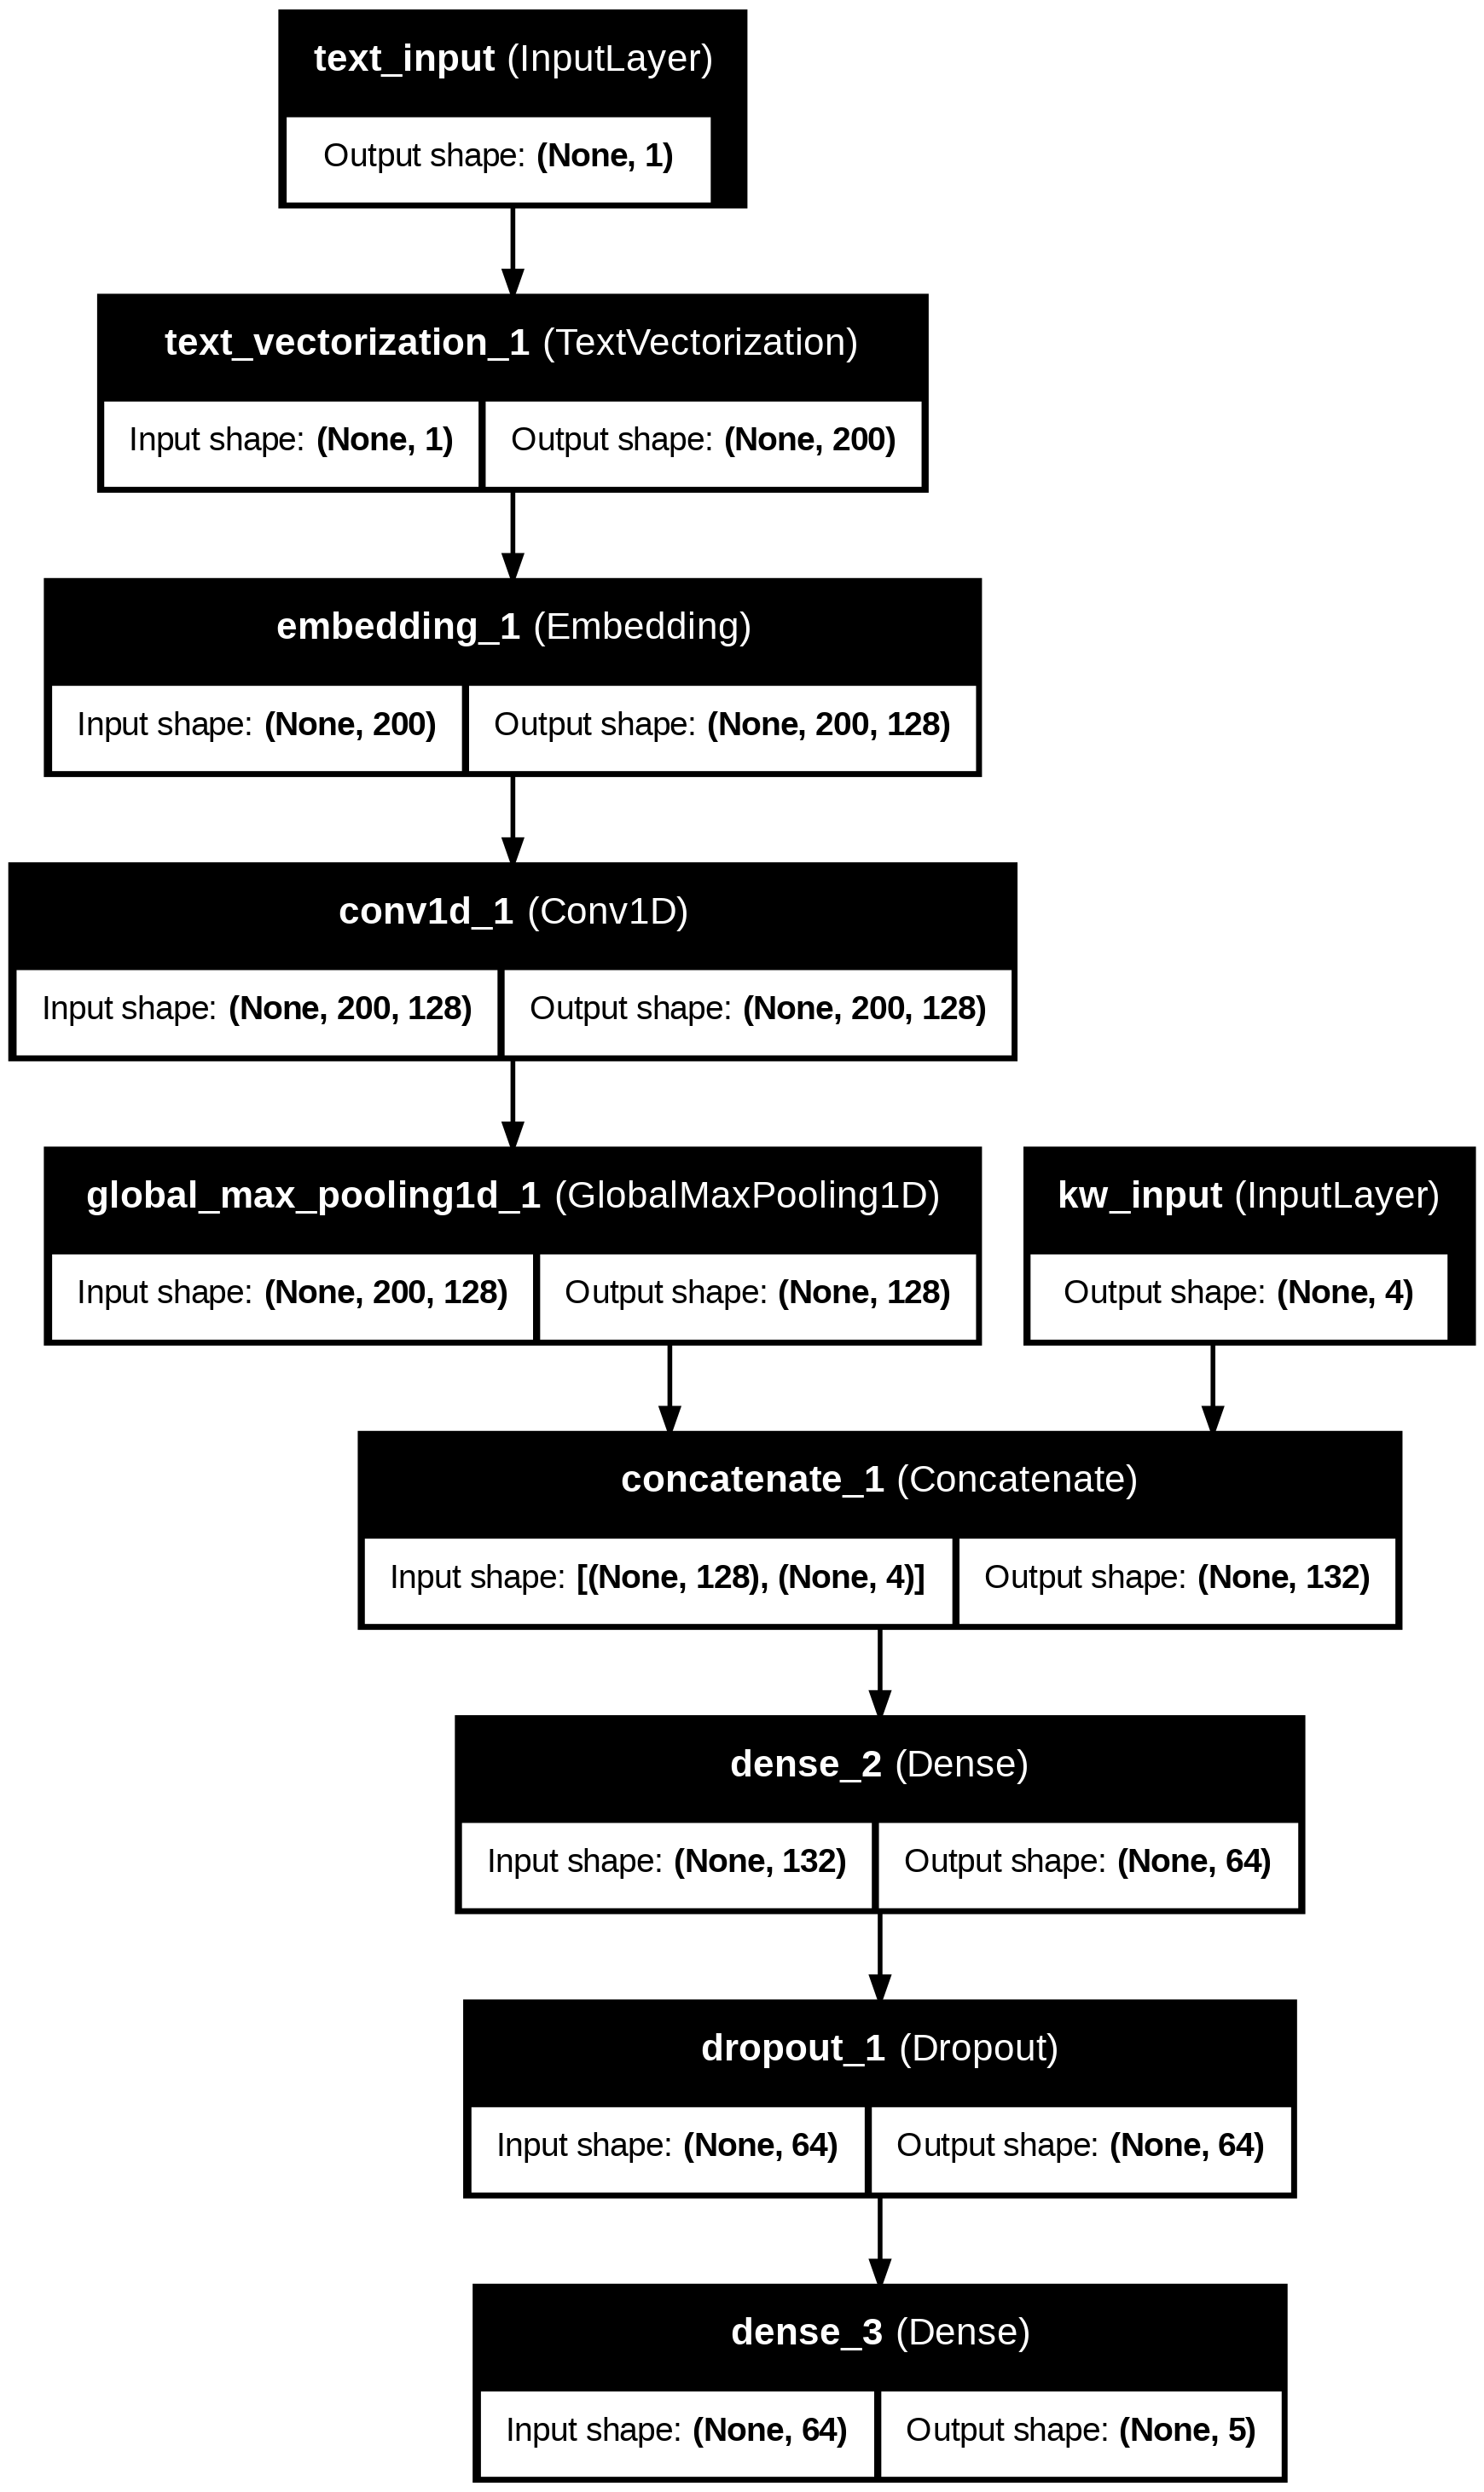

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file="model_structure.png", show_shapes=True, show_layer_names=True)


In [ ]:
history = model.fit(
    {"text_input": X_train_text, "kw_input": X_train_kw},
    y_train,
    validation_data=({"text_input": X_test_text, "kw_input": X_test_kw}, y_test),
    epochs=5,
    batch_size=8
)


Epoch 1/5
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.4503 - loss: 1.4225 - val_accuracy: 0.9055 - val_loss: 0.2634
Epoch 2/5
101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.9401 - loss: 0.2189 - val_accuracy: 0.9701 - val_loss: 0.1505
Epoch 3/5
101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9865 - loss: 0.0666 - val_accuracy: 0.9701 - val_loss: 0.1218
Epoch 4/5
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 1.0000 - loss: 0.0181 - val_accuracy: 0.9751 - val_loss: 0.1160
Epoch 5/5
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 1.0000 - loss: 0.0055 - val_accuracy: 0.9751 - val_loss: 0.1210


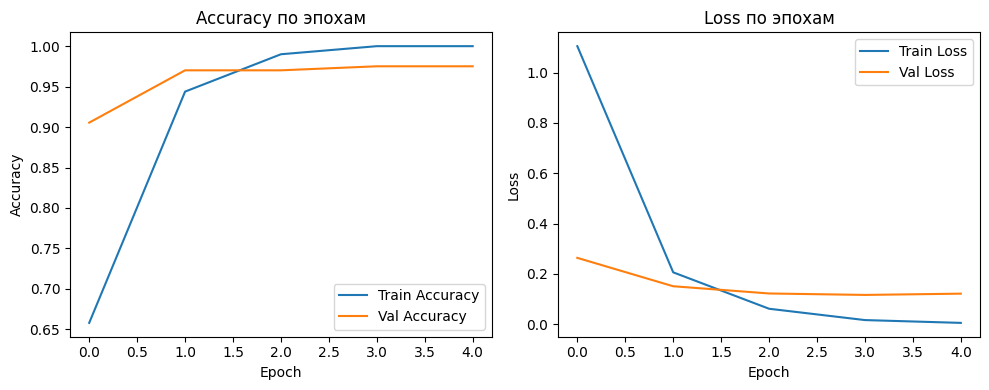

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy по эпохам')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss по эпохам')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
def predict_ministry(title, content):
    text = title + " " + content
    clean = clean_text(text)
    kw_vec = keyword_vector(text, MINISTRY_KEYWORDS)

    text_input_arr = np.array([clean], dtype=object)
    kw_input_arr = np.array([kw_vec], dtype=np.float32)

    pred = model.predict({"text_input": text_input_arr, "kw_input": kw_input_arr}, verbose=0)
    return label_encoder.inverse_transform([np.argmax(pred)])[0]


In [ ]:
headline = "В порядок предоставления земельных участков внесены изменения"
newsText = "Комитет управления земельными ресурсами Министерства сельского хозяйства Республики Казахстан информирует о внесении изменений в Приказ Министра сельского хозяйства Республики Казахстан от 1 октября 2020 года №301 «Об утверждении Правил предоставления земельных участков». В частности, изменения затронули Приложение 17, в котором изложен порядок предоставления земельных участков из земель городов республиканского значения, столицы, а также городов областного и районного значения. В документе определён порядок оформления долей в общей долевой собственности либо в общем долевом землепользовании. Внедрение данных норм направлено на решение актуальных проблем, с которыми сталкиваются заявители при оформлении земельных участков, связанных с долевым участием. Процессы оптимизированы и адаптированы для дальнейшей автоматизации, что повысит прозрачность и упростит процедуру оформления. В настоящее время проект Приказа находится на стадии государственной регистрации. После завершения процедуры и официального опубликования документ вступит в силу по истечении десяти календарных дней. Комитет управления земельными ресурсами МСХ РК продолжает работу по совершенствованию государственных услуг в сфере земельных отношений и упрощению административных процедур в интересах граждан и бизнеса."

In [ ]:
print(predict_ministry(
    headline,
    newsText
))



Министерство сельского хозяйства


In [ ]:
model.save("ministry_classifier_model.keras")


In [ ]:
model.export("saved_model_folder")


Saved artifact at 'saved_model_folder'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 1), dtype=tf.string, name='text_input'), TensorSpec(shape=(None, 4), dtype=tf.float32, name='kw_input')]
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  137173317358928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137173317358544: TensorSpec(shape=(), dtype=tf.int64, name=None)
  137173317074000: TensorSpec(shape=(), dtype=tf.string, name=None)
  137173317074768: TensorSpec(shape=(), dtype=tf.int64, name=None)
  137173317074576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137173317358736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137173317356816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137173317357584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137173317357200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137173317359888: TensorSpec(shape